In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import re, string , unicodedata
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow import keras
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import nltk
nltk.download('stopwords')
#nltk.download()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_json('/content/drive/MyDrive/Sarcasm Detection/Sarcasm_Headlines_Dataset.json', lines = True, orient = 'columns')
df_v2 = pd.read_json('/content/drive/MyDrive/Sarcasm Detection/Sarcasm_Headlines_Dataset_v2.json', lines = True, orient = 'columns')
df = pd.concat([df, df_v2])
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
print(df.isna().sum())
print('')
df.drop(columns= ['article_link'], inplace= True)
df.info()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      55328 non-null  object
 1   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [6]:
# convert to lowercase
df['headline'] = df['headline'].apply(lambda x: x.lower())

# remove punctuation
df['headline'] = df['headline'].apply(lambda x: ' '.join(
    word.strip(string.punctuation) for word in x.split()))

# remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
headline = []
for sentence in df['headline']:
    filtered_list = []
    for word in sentence.split():
        if word not in stopwords:
            filtered_list.append(word)
    join_string = ' '.join([str(i) for i in filtered_list])
    headline.append(join_string)
df['headline'] = headline

In [7]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size = 0.1)

train_sentences = list(train_data['headline'])
train_labels = list(train_data['is_sarcastic'])

test_sentences = list(test_data['headline'])
test_labels = list(test_data['is_sarcastic'])

train_sentences = np.array(train_sentences)
test_sentences = np.array(test_sentences)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


25.0

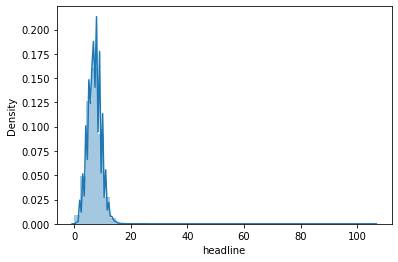

In [8]:
import seaborn as sns
headline_lengths = df['headline'].apply(lambda x: len(x.split())) 
sns.distplot(headline_lengths)
headline_lengths.quantile(0.9999)
### 99.99% sentences have less than 25 or less words

In [9]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-768_A-12'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'


In [10]:
!pip install -q -U "tensorflow-text==2.8.*"
import tensorflow_hub as hub
import tensorflow_text as text

In [11]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
"""
text_test = ['trump flys to north korea!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


 We have the 3 outputs from the preprocessing that a BERT model 
 would use (input_words_id, input_mask and input_type_ids).
"""

In [12]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
"""
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')
"""

The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

In [13]:
def BERTModel():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(100, activation='relu', name='FC1')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='FC2')(net)
  # Use inputs and outputs to return the final model
  return tf.keras.Model(inputs = text_input, outputs = net)  

In [14]:
model = BERTModel()

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss= 'binary_crossentropy', optimizer= optimizer, metrics= ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [16]:
#train_sentences = np.array(train_sentences)
#test_sentences = np.array(test_sentences)
history = model.fit(train_sentences, train_labels, epochs= 10, validation_split= 0.2, batch_size=32)

Epoch 1/10
1245/1245 [==============================] - 281s 222ms/step - loss: 0.4728 - accuracy: 0.7673 - val_loss: 0.3585 - val_accuracy: 0.8375
Epoch 2/10
1245/1245 [==============================] - 276s 222ms/step - loss: 0.3256 - accuracy: 0.8586 - val_loss: 0.2990 - val_accuracy: 0.8707
Epoch 3/10
1245/1245 [==============================] - 277s 222ms/step - loss: 0.2470 - accuracy: 0.8985 - val_loss: 0.2716 - val_accuracy: 0.8932
Epoch 4/10
1245/1245 [==============================] - 275s 221ms/step - loss: 0.1806 - accuracy: 0.9293 - val_loss: 0.2254 - val_accuracy: 0.9177
Epoch 5/10
1245/1245 [==============================] - 276s 222ms/step - loss: 0.1319 - accuracy: 0.9506 - val_loss: 0.1975 - val_accuracy: 0.9355
Epoch 6/10
1245/1245 [==============================] - 276s 221ms/step - loss: 0.0959 - accuracy: 0.9650 - val_loss: 0.1894 - val_accuracy: 0.9427
Epoch 7/10
1245/1245 [==============================] - 274s 220ms/step - loss: 0.0698 - accuracy: 0.9746 - val_

In [17]:
res = (model.predict(test_sentences) > 0.5).astype(int).reshape(-1)
print("Accuracy", accuracy_score(y_true = test_labels, y_pred = res))
print("Recall", recall_score(y_true = test_labels, y_pred = res))
print("Precision", + precision_score(y_true = test_labels, y_pred = res))
print("F1-score", + f1_score(y_true = test_labels, y_pred = res))

Accuracy 0.952286282306163
Recall 0.9278996865203761
Precision 0.9673202614379085
F1-score 0.9471999999999999


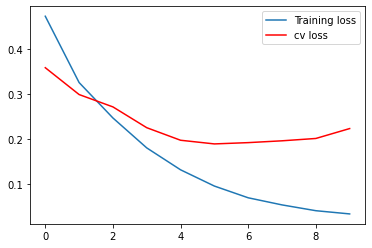

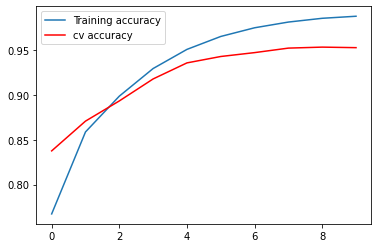

In [18]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], color='red', label='cv loss')
plt.legend()
plt.figure()
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='cv accuracy')
plt.legend()